In [15]:
import sys
sys.path.append('D:/tennis_v2/')
print(sys.path)
import os
import cv2
import torch
from utils.utils import prepare_json, load_config
import torchvision.transforms as transforms
import numpy as np
import pandas as pd


from model.wasb import HRNet
from assets.track import Tracker
from utils.LoadData import resize_feature

from assets.bounce import detect_bounces
import matplotlib.pyplot as plt

from utils.kalman_filter import KalmanFilter
import websocket
import requests
from utils.camera_home_graph import undistort_image
# from asset.tennis_v1.LoadData import resize_feature

%load_ext autoreload
%autoreload 2

['c:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'c:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python310', '', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\Administrator\\AppData\\Roaming\\Python\\Python310\\site-packages\\Pythonwin', 'c:\\Users\\Administrator\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'D:/tennis_v2/', 'D:/tennis_v2/', 'D:/tennis_v2/']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# --- Constants and Configuration ---
CURRENT_DIR = 'd:/tennis_v2/'
MODEL_PATH = f"{CURRENT_DIR}/weights/wasb_tennis_best.pth"
BOUNCE_DETECTOR_PATH = f"{CURRENT_DIR}/weights/ctb_regr_bounce.cbm"
DELAY = 15  # 延迟帧数

csv = 'test_02'
video_input_path = 'd:/tennis_v2/iphone_test_02.mp4'
video_output_path = 'd:/tennis_v2/inference/HRnetv3_' + video_input_path.split('/')[-1]
output_csv_path = 'd:/tennis_v2/inference/HRnetv3_' + csv + '.csv'

In [ ]:
current_dir = 'd:/tennis_v2/'

def preprocess_frame(frame, transform):
    return transform(frame)

def run_inference(input_path, output_path="", output_csv_path="", overlay=False):
    # load config
    config = load_config(f"{CURRENT_DIR}/config.yaml")

    # send json data socket
    ws = websocket.WebSocket()
    ws.connect(config['socket_url'])

    # cap url address
    response  = requests.get(config['cap_url'])
    if response.status_code == 200:   
        rtmp_addr = response.json()['data']['videoUrl']
        print(f'success get the camera: {rtmp_addr}')
    else:
        print(f'Error: {response.status_code}')

    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['inp_height'], config['inp_width'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    model = HRNet(cfg=config).to(device)
    checkpoint = torch.load(CURRENT_DIR + config['model_path'], map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    model.eval()

    tracker = Tracker()
    cap = cv2.VideoCapture(rtmp_addr)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_number = 0
    frames_buffer = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = undistort_image(frame)
        frames_buffer.append(frame)
        
        # 只有当缓冲区满时才进行处理
        if len(frames_buffer) == config['frames_in']:
            # 预处理帧时保留原始彩色图像
            processed_frames = []
            color_frames = []  # 新增：保存原始彩色帧用于显示
            for f in frames_buffer:
                processed = preprocess_frame(f, transform)  # 灰度处理可能在这里发生
                processed_frames.append(processed)
                color_frames.append(f.copy())  # 保存原始彩色帧的副本
                
            input_tensor = torch.cat(processed_frames, dim=0).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(input_tensor)[0]

            # 处理每个输出帧
            for frame_idx in range(config['frames_out']):  # 修改循环变量名为frame_idx
                output = outputs[0][frame_idx]
                heatmap = torch.sigmoid(output).squeeze().cpu().numpy()
                heatmap = cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_LINEAR)
                
                # 更新跟踪器
                active_objects = tracker.process_frame(heatmap)
            
                # 获取对应的原始彩色帧
                display_frame = color_frames[frame_idx % len(color_frames)].copy()  # 循环使用缓冲帧
                
                # 绘制跟踪结果
                for obj in active_objects:
                    x1, y1, x2, y2 = obj.get_bbox(base_size=8)
                    
                    # 绘制边界框
                    color = (0, 255, 0)  # BGR格式
                    cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 2)
                    
                    # 绘制ID标签
                    label_pos = (x1, y1 - 10) if y1 > 20 else (x1, y1 + 20)
                    cv2.putText(display_frame, f"ID:{obj.id}", label_pos, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                    
                    # 绘制运动轨迹（修改循环变量名为j）
                    trail_points = obj.get_trail_points()
                    for j in range(1, len(trail_points)):
                        alpha = j / len(trail_points)
                        thickness = int(2 * alpha) + 1
                        cv2.line(display_frame, 
                                trail_points[j-1], 
                                trail_points[j],
                                (0, int(255*(1-alpha)), int(255*alpha)), 
                                thickness)

                # 显示处理后的帧
                cv2.imshow("Tracking", display_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    exit()
            
            frames_buffer = []  # 清空缓冲

    # 结束处理
    cap.release()
    cv2.destroyAllWindows()

In [14]:
outputs = run_inference(video_input_path, video_output_path, output_csv_path)

success get the camera: rtmp://rtmp03open.ys7.com:1935/v3/openlive/BB8121883_1_1?expire=1740807028&id=815576661940617216&t=7b7788d1b1ac78dd49404bc2aa8a8e050c686312a89927ca64de637ff89fac54&ev=100


KeyboardInterrupt: 

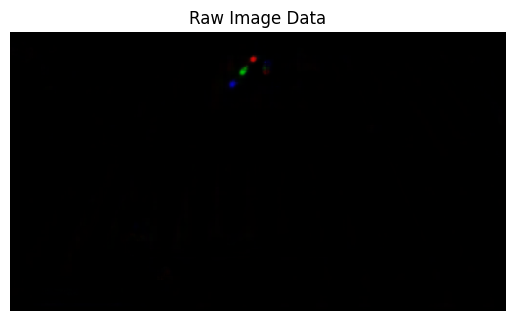

In [45]:
# 去掉 batch 维度： (3, 288, 512)
img_tensor = outputs[0]
img_tensor = torch.sigmoid(img_tensor)

# permute 到 (H, W, C)： (288, 512, 3)
img_tensor = img_tensor .permute(1, 2, 0)

img_np = img_tensor.numpy()

plt.imshow(img_np)
plt.title("Raw Image Data")
plt.axis("off")
plt.show()

In [47]:
output = outputs[0]
heatmap = output.squeeze().cpu().numpy()
# print(output. shape, heatmap.shape)

heatmap = cv2.resize(heatmap, (1280, 720), interpolation=cv2.INTER_LINEAR)
heatmap = (heatmap > 0.5).astype(np.float32) * heatmap

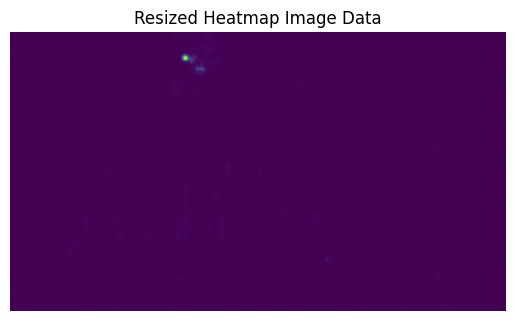

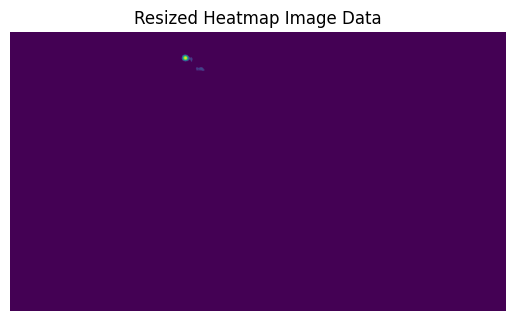

In [379]:
heatmap_filter = (heatmap_resized > 0.11).astype(np.float32) * heatmap_resized
# 显示图像
plt.imshow(heatmap_filter)  # 再次转换为 [720, 1280, 3] 格式
plt.title("Resized Heatmap Image Data")
plt.axis("off")
plt.show()

In [ ]:
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats((heatmap_filter > 0).astype(np.uint8), connectivity=8)
# blob_sum